PROJECT 4 : Handwritten Character Recognition on EMNIST with CNN  

The goal of this project is to build, train, and improve a Convolutional Neural Network (CNN)
for handwritten character recognition using the EMNIST dataset. You will also use Weights &
Biases (wandb) to log experiments and perform hyperparameter tuning in order to optimize your
model’s performance.

STEP 1 : Data Preparation :


Download and load and normalize the EMNIST dataset :

In [9]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
train_data = datasets.EMNIST(root="./data", split="balanced", train=True, download=True, transform=transform)
test_data  = datasets.EMNIST(root="./data", split="balanced", train=False, download=True, transform=transform)

create train/validation/test splits :

In [10]:
train_size = int(0.8 * len(train_data))
val_size   = len(train_data) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_data, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader  = DataLoader(test_data, batch_size=64, shuffle=False)

Visualize some sample images to understand the dataset :

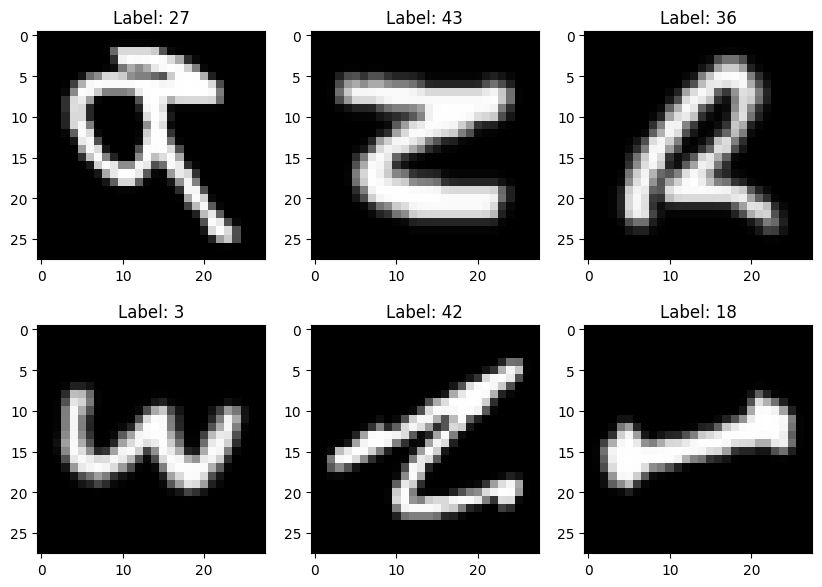

In [11]:
import matplotlib.pyplot as plt
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure(figsize=(10, 7))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(example_data[i][0], cmap="gray")
    plt.title(f"Label: {example_targets[i].item()}")
plt.show()

STEP 2 : Baseline CNN Model :

 * Build a simple CNN architecture (a few convolution + pooling layers, followed by fully
connected layers).
*  Train the model with default hyperparameters.
*  Evaluate the baseline accuracy on the test set.

In [12]:
import torch.nn as nn
import torch.nn.functional as F
class SimpleCNN(nn.Module):
    def __init__(self, conv_filters=32, dropout_rate=0.3):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, conv_filters, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(conv_filters, conv_filters*2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear((conv_filters*2) * 7 * 7, 128)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(128, 47)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

STEP 3 : Integrating wandb :

Load wandb :

In [13]:
import wandb
wandb.login()

True

Set up wandb to log metrics such as training/validation loss and accuracy :

In [14]:
def train_model(config=None):
    with wandb.init(config=config):
        config = wandb.config
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = SimpleCNN(conv_filters=config.conv_filters, dropout_rate=config.dropout).to(device)
        criterion = nn.CrossEntropyLoss()
        if config.optimizer == "adam":
            optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)
        else:
            optimizer = torch.optim.SGD(model.parameters(), lr=config.lr, momentum=0.9)
        for epoch in range(config.epochs):
            model.train()
            train_loss, train_correct = 0, 0
            for data, target in train_loader:
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
                train_correct += (output.argmax(1) == target).sum().item()
            model.eval()
            val_loss, val_correct = 0, 0
            with torch.no_grad():
                for data, target in val_loader:
                    data, target = data.to(device), target.to(device)
                    output = model(data)
                    loss = criterion(output, target)
                    val_loss += loss.item()
                    val_correct += (output.argmax(1) == target).sum().item()
            wandb.log({
                "epoch": epoch,
                "train_loss": train_loss/len(train_loader),
                "train_acc": train_correct/len(train_dataset),
                "val_loss": val_loss/len(val_loader),
                "val_acc": val_correct/len(val_dataset)
            })

STEP 4 : Hyperparameter Tuning :


In [15]:
sweep_config = {
    "method": "random",
    "metric": {"name": "val_acc", "goal": "maximize"},
    "parameters": {
        "lr": {"values": [0.001, 0.0005, 0.01]},
        "optimizer": {"values": ["adam", "sgd"]},
        "conv_filters": {"values": [16, 32, 64]},
        "dropout": {"values": [0.3, 0.5]},
        "epochs": {"value": 5}
    }
}
sweep_id = wandb.sweep(sweep_config, project="emnist-cnn")
wandb.agent(sweep_id, train_model, count=5)

Create sweep with ID: t79gdyuo
Sweep URL: https://wandb.ai/rmelika-rz-2004-khajeh-nasir/emnist-cnn/sweeps/t79gdyuo


wandb: Agent Starting Run: g708z4b4 with config:
wandb: 	conv_filters: 16
wandb: 	dropout: 0.5
wandb: 	epochs: 5
wandb: 	lr: 0.0005
wandb: 	optimizer: sgd


epoch,▁▃▅▆█
train_acc,▁▅▇▇█
train_loss,█▄▂▁▁
val_acc,▁▅▇▇█
val_loss,█▃▂▁▁
epoch,4
train_acc,0.66934
train_loss,1.08448
val_acc,0.76547
val_loss,0.75102


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: nsh0s4qk with config:
wandb: 	conv_filters: 16
wandb: 	dropout: 0.3
wandb: 	epochs: 5
wandb: 	lr: 0.001
wandb: 	optimizer: adam


epoch,▁▃▅▆█
train_acc,▁▆▇██
train_loss,█▃▂▁▁
val_acc,▁▄▅▇█
val_loss,█▅▃▂▁
epoch,4
train_acc,0.83747
train_loss,0.47349
val_acc,0.86494
val_loss,0.38847


wandb: Agent Starting Run: b7o88lt3 with config:
wandb: 	conv_filters: 16
wandb: 	dropout: 0.3
wandb: 	epochs: 5
wandb: 	lr: 0.01
wandb: 	optimizer: adam


wandb: Ctrl + C detected. Stopping sweep.


 STEP 5 : Reporting Results :

Retrieve the Best Sweep Run :

In [5]:
api = wandb.Api()
sweep = api.sweep("rmelika-rz-2004-khajeh-nasir/emnist-cnn/5twmwepx")
# Find the best run by validation accuracy
best_run = max(sweep.runs, key=lambda run: run.summary.get("val_acc", 0))
print(f"Best Validation Accuracy: {best_run.summary['val_acc']}")
print(f"Hyperparameters: {best_run.config}")

Best Validation Accuracy: 0.8671099290780142
Hyperparameters: {'lr': 0.001, 'epochs': 5, 'dropout': 0.5, 'optimizer': 'adam', 'conv_filters': 16}


Plot Accuracy and Loss Curves :

In [6]:
train_acc = best_run.history(keys=["train_acc"])["train_acc"]
val_acc = best_run.history(keys=["val_acc"])["val_acc"]
train_loss = best_run.history(keys=["train_loss"])["train_loss"]
val_loss = best_run.history(keys=["val_loss"])["val_loss"]
epochs = range(1, len(train_acc) + 1)

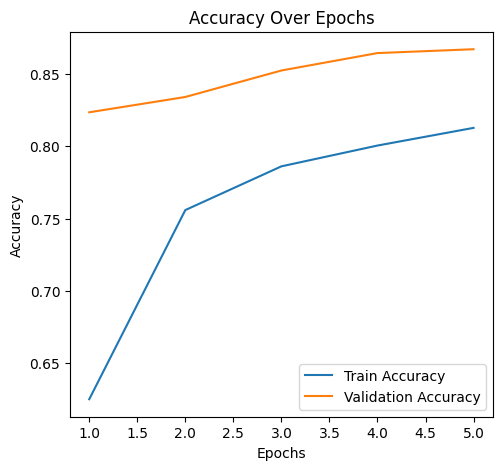

In [16]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, label='Train Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

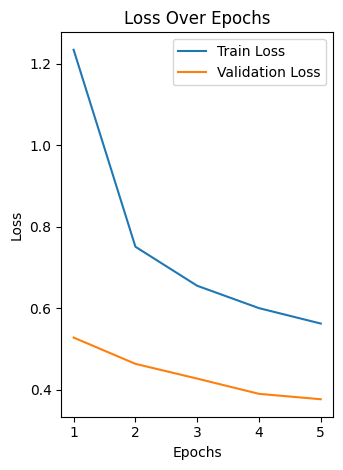

In [17]:
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

Short Analysis of Hyperparameters Impact :

1. Learning Rate (lr):

     Too high → unstable training

    too low → slow convergence

2. Optimizer:

    Adam often converges faster than SGD on EMNIST.

3. Conv Filters:

   More filters → better feature extraction but more parameters.

   Fewer filters (e.g., 16) → less expressive power, may miss subtle patterns in letters.

4. Dropout:

    Low dropout (0–0.3) → less regularization → might overfit on small datasets.

    High dropout (0.5–0.7) → strong regularization → can underfit if network is small.


📌EMNIST CNN Hyperparameter Sweep Results :

We performed a hyperparameter sweep on a simple CNN model for the EMNIST dataset, testing different configurations of convolutional filters, dropout rates, optimizers, and learning rates. The best run (Run lyric-sweep-2) achieved a training accuracy of 83.7% and a validation accuracy of 86.5% after 5 epochs, with corresponding losses of 0.473 for training and 0.388 for validation.

This configuration used 16 convolutional filters, a dropout rate of 0.3, Adam optimizer, and a relatively high learning rate of 0.01. Despite the smaller number of filters, the model generalized well, likely due to the regularizing effect of dropout. The high learning rate allowed the optimizer to converge quickly, though care must be taken in other configurations to avoid instability.